<a href="https://colab.research.google.com/github/KushagraIndurkhya/bilateral-filtering/blob/main/bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install -y libopencv-dev

In [ ]:
!find .. -name 'libopencv*'

In [ ]:
!pkg-config --cflags --libs opencv4

In [ ]:
!mkdir -p output

In [57]:
%%writefile bilateral.cpp

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <thread>
#include <chrono>

using namespace cv;
using namespace std;

float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

double gaussian(float x, double sigma) {
    return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));

}

void applyBilateralFilter(Mat source, Mat filteredImage, int x, int y, int diameter, double sigmaI, double sigmaS) {
    double iFiltered = 0;
    double wP = 0;
    int neighbor_x = 0;
    int neighbor_y = 0;
    int half = diameter / 2;

    for(int i = 0; i < diameter; i++) {
        for(int j = 0; j < diameter; j++) {
            neighbor_x = x - (half - i);
            neighbor_y = y - (half - j);
            double gi = gaussian(source.at<uchar>(neighbor_x, neighbor_y) - source.at<uchar>(x, y), sigmaI);
            double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
            double w = gi * gs;
            iFiltered = iFiltered + source.at<uchar>(neighbor_x, neighbor_y) * w;
            wP = wP + w;
        }
    }
    iFiltered = iFiltered / wP;
    filteredImage.at<double>(x, y) = iFiltered;


}

Mat addPadding(Mat source, int radius) {
    int row = source.rows;
    int col = source.cols;
    int paddedRow = row + 2 * radius;
    int paddedCol = col + 2 * radius;
    Mat paddedImage = Mat::zeros(paddedRow, paddedCol, source.type());
    for(int i = 0; i < row; i++) {
        for(int j = 0; j < col; j++) {
            paddedImage.at<uchar>(i + radius, j + radius) = source.at<uchar>(i, j);
        }
    }
    return paddedImage;
}


Mat removePadding(Mat source, int radius) {
    int height = source.rows - 2 * radius;
    int width = source.cols - 2 * radius;

    Mat dest = Mat::zeros(height, width,CV_64F); 

    for (int i = radius; i < source.rows - radius; i++) {
        for (int j = radius; j < source.cols - radius; j++) {
            dest.at<uchar>(i - radius, j - radius) = source.at<uchar>(i, j);
        }
    }

    return dest;
}


Mat bilateralFilterSeq(Mat source, int diameter, double sigmaI, double sigmaS) {
    Mat filteredImage = Mat::zeros(source.rows,source.cols,CV_64F);

    //int radius= diameter / 2;
    //source=addPadding(source,radius);
    int radius=0;

    int width = source.cols;
    int height = source.rows;

    for(int i = radius; i < height - radius; i++) {
        for(int j = radius; j < width - radius; j++) {
            applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
        }
    }
    //filteredImage=removePadding(filteredImage,radius);
    return filteredImage;
}

Mat bilateralFilterParallel(Mat source, int diameter, double sigmaI, double sigmaS) {
    Mat filteredImage = Mat::zeros(source.rows, source.cols, CV_64F);
    int radius = 0;

    int width = source.cols;
    int height = source.rows;

    //int numThreads = thread::hardware_concurrency();
    int numThreads = 50;
    vector<thread> threads;

    int rowsPerThread = height / numThreads;

    int start = radius;
    int end = start + rowsPerThread;

    for (int t = 0; t < numThreads; t++) {
        if (t == numThreads - 1) {
            end = height - radius;
        }

        threads.push_back(thread([&, start, end]() {
            for (int i = start; i < end; i++) {
                for (int j = radius; j < width - radius; j++) {
                    applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
                }
            }
        }));

        start = end;
        end = start + rowsPerThread;
    }

    for (auto &t : threads) {
        t.join();
    }

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    

    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageSeq = bilateralFilterSeq(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();


    start = chrono::high_resolution_clock::now();
    Mat filteredImageOpenCV;
    bilateralFilter(src, filteredImageOpenCV, diameter,sigma_intensity,sigma_space);
    end = chrono::high_resolution_clock::now();
    auto durationOpenCV = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    start = chrono::high_resolution_clock::now();
    Mat filteredImageParallel = bilateralFilterParallel(src, diameter, sigma_intensity,sigma_space);
    end = chrono::high_resolution_clock::now();
    auto durationParallel = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Sequential: "<<durationSeq<<"ms \n";
    cout<<"Parallel: "<<durationParallel<<"ms"<<" using "<<thread::hardware_concurrency()<<" threads\n";

    imwrite("output/original_image_grayscale.png", src);
    imwrite("output/filtered_image_OpenCV.png", filteredImageOpenCV);
    imwrite("output/filtered_image_Seq.png", filteredImageSeq);

    return 0;
}

Overwriting bilateral.cpp


In [58]:
!g++ -std=c++11 -pthread -I/usr/include/opencv4/opencv -I/usr/include/opencv4 bilateral.cpp -o bilateral -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core
!./bilateral input/images.jpeg 15 75 75

Sequential: 3843ms 
Parallel: 3235ms using 2 threads
OpenCV: 9ms 


In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread("input/images.jpeg")
diameter=3
sigma_for_gaussian=75

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussian_blur = cv2.GaussianBlur(gray, (diameter, diameter), sigma_for_gaussian)
cv2.imwrite("output/gaussian_blurred_image.png", gaussian_blur)

mean_filter=cv2.blur(img, (diameter, diameter))
cv2.imwrite("output/mean_filtered_image.png", mean_filter)

median_filter=cv2.medianBlur(img, diameter)
cv2.imwrite("output/median_filtered_image.png", median_filter)


True

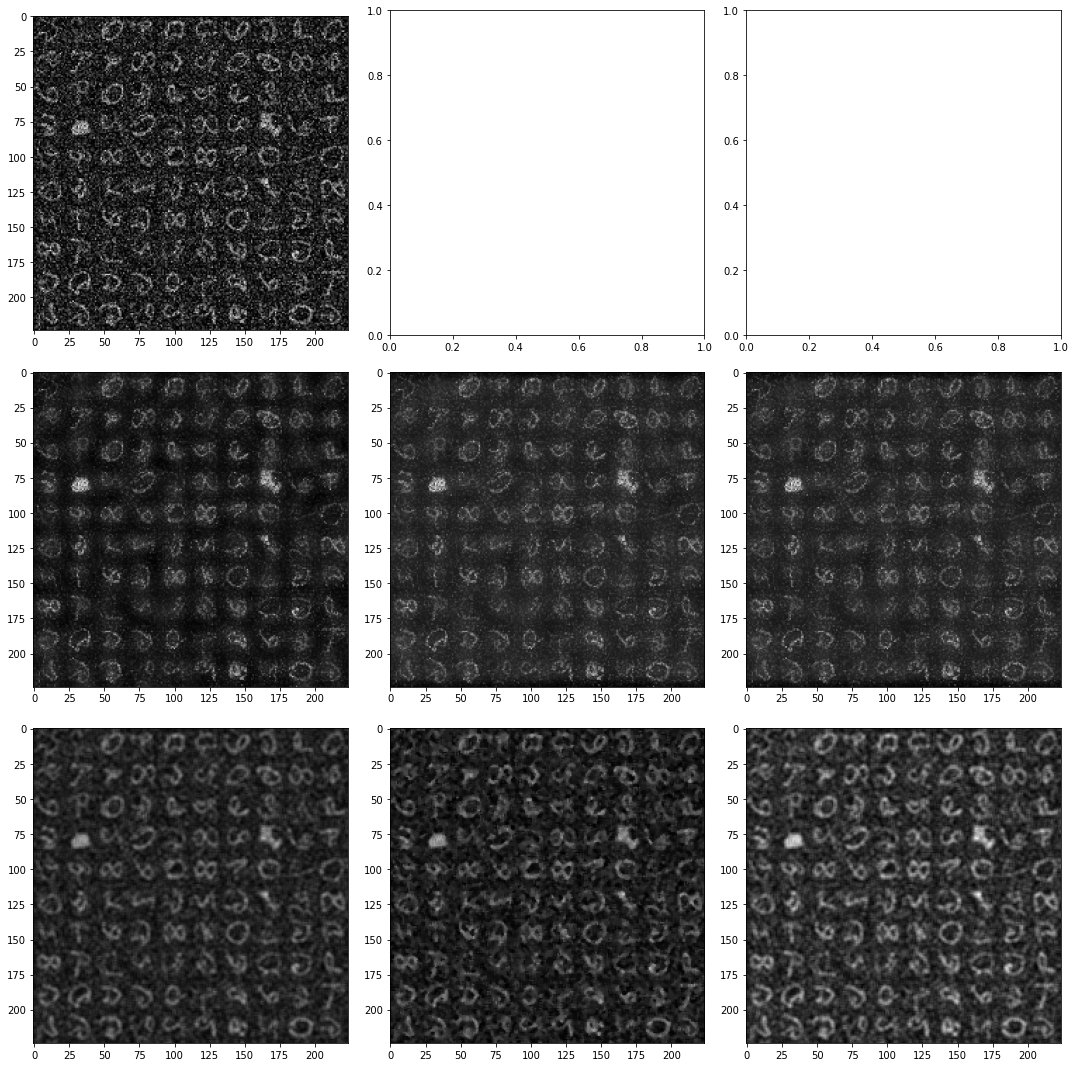

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread("output/original_image_grayscale.png")
img2 = mpimg.imread("output/filtered_image_Parallel.png")
img3 = mpimg.imread("output/filtered_image_Seq.png")
img4 = mpimg.imread("output/mean_filtered_image.png")
img5 = mpimg.imread("output/median_filtered_image.png")
img6 = mpimg.imread("output/gaussian_blurred_image.png")
img7 = mpimg.imread("output/filtered_image_OpenCV.png")


fig, axs = plt.subplots(3, 3, figsize=(15,15))

axs[0,0].imshow(img1, cmap='gray')
axs[1,0].imshow(img7, cmap='gray')
axs[1,1].imshow(img2, cmap='gray')
axs[1,2].imshow(img3, cmap='gray')
axs[2,0].imshow(img4, cmap='gray')
axs[2,1].imshow(img5, cmap='gray')
axs[2,2].imshow(img6, cmap='gray')



plt.tight_layout()
plt.show()

In [ ]:
!rm *.png *.cpp
!rm bilateral output